## Домашнее задание

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

Files already downloaded and verified


In [3]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [4]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])




train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [6]:
classes = dataset.classes

torch.Size([128, 3, 32, 32])
keyboard


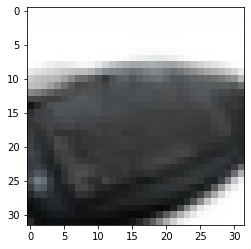

In [7]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class Net(nn.Module):
    def __init__(self, bn_momentum = 0.1):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(64, momentum=bn_momentum),
                      nn.ReLU(),
                      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(128, momentum=bn_momentum),
                      nn.ReLU()
                      )
        
        self.enc_conv1 = nn.Sequential(
                      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(256, momentum=bn_momentum),
                      nn.ReLU(),
                      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(512, momentum=bn_momentum),
                      nn.ReLU(),
                      nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(256, momentum=bn_momentum),
                      nn.ReLU()
                  )
        
        self.enc_conv2 = nn.Sequential(
                      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(256, momentum=bn_momentum),
                      nn.ReLU(),
                      nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(128, momentum=bn_momentum),
                      nn.ReLU(),
                      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(64, momentum=bn_momentum),
                      nn.ReLU()
                  )
        
        self.out = torch.nn.Linear(1024, 100)
        self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
        self.dp = nn.Dropout(0.4)
     
        
    def forward(self, x):

        x = self.pool(self.enc_conv0(x))
        x = self.pool(self.enc_conv1(x))
        x = self.pool(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        return self.out(x)
        
net = Net().to(device)
print(net)

Net(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc_conv1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (enc_conv2): Sequenti

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [11]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
             ReLU-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
             ReLU-13          [-1, 512, 16, 16]               0
           Conv2d-14          [-1, 256,

In [12]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.038. Acc: 0.016. Test acc: 0.009
Epoch [1/5]. Step [301/372]. Loss: 0.035. Acc: 0.031. Test acc: 0.063
Epoch [2/5]. Step [1/372]. Loss: 0.032. Acc: 0.047. Test acc: 0.075
Epoch [2/5]. Step [301/372]. Loss: 0.032. Acc: 0.071. Test acc: 0.100
Epoch [3/5]. Step [1/372]. Loss: 0.031. Acc: 0.086. Test acc: 0.106
Epoch [3/5]. Step [301/372]. Loss: 0.030. Acc: 0.096. Test acc: 0.143
Epoch [4/5]. Step [1/372]. Loss: 0.029. Acc: 0.141. Test acc: 0.128
Epoch [4/5]. Step [301/372]. Loss: 0.029. Acc: 0.127. Test acc: 0.149
Epoch [5/5]. Step [1/372]. Loss: 0.027. Acc: 0.133. Test acc: 0.140
Epoch [5/5]. Step [301/372]. Loss: 0.028. Acc: 0.157. Test acc: 0.153
Training is finished!


## Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50

In [13]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [16]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [17]:
resnet50 = resnet50.to(device)

In [18]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [20]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.037. Acc: 0.016. Test acc: 0.008
Epoch [1/5]. Step [301/372]. Loss: 0.020. Acc: 0.395. Test acc: 0.503
Epoch [2/5]. Step [1/372]. Loss: 0.014. Acc: 0.508. Test acc: 0.524
Epoch [2/5]. Step [301/372]. Loss: 0.014. Acc: 0.534. Test acc: 0.541
Epoch [3/5]. Step [1/372]. Loss: 0.012. Acc: 0.570. Test acc: 0.520
Epoch [3/5]. Step [301/372]. Loss: 0.012. Acc: 0.565. Test acc: 0.568
Epoch [4/5]. Step [1/372]. Loss: 0.012. Acc: 0.562. Test acc: 0.558
Epoch [4/5]. Step [301/372]. Loss: 0.012. Acc: 0.582. Test acc: 0.572
Epoch [5/5]. Step [1/372]. Loss: 0.013. Acc: 0.547. Test acc: 0.557
Epoch [5/5]. Step [301/372]. Loss: 0.012. Acc: 0.586. Test acc: 0.576
Training is finished!


## Аугментация данных

In [22]:
from scipy import misc
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [23]:
transformations = transforms.Compose([
    transforms.Resize(size=(255, 255), ),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=2, contrast=2),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, transformations)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [25]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [26]:
resnet50.fc = nn.Linear(2048, 100)
resnet50 = resnet50.to(device)

In [27]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [28]:
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.000. Test acc: 0.011
Epoch [1/5]. Step [301/372]. Loss: 0.028. Acc: 0.189. Test acc: 0.396
Epoch [2/5]. Step [1/372]. Loss: 0.024. Acc: 0.297. Test acc: 0.412
Epoch [2/5]. Step [301/372]. Loss: 0.023. Acc: 0.301. Test acc: 0.464
Epoch [3/5]. Step [1/372]. Loss: 0.025. Acc: 0.266. Test acc: 0.454
Epoch [3/5]. Step [301/372]. Loss: 0.022. Acc: 0.326. Test acc: 0.474
Epoch [4/5]. Step [1/372]. Loss: 0.017. Acc: 0.477. Test acc: 0.461
Epoch [4/5]. Step [301/372]. Loss: 0.021. Acc: 0.337. Test acc: 0.489
Epoch [5/5]. Step [1/372]. Loss: 0.021. Acc: 0.281. Test acc: 0.492
Epoch [5/5]. Step [301/372]. Loss: 0.021. Acc: 0.346. Test acc: 0.496
Training is finished!
